## **Weed or Crop? Training a deep learning model to identify weed and crop species.**

Files are all located in Google Drive, so it is necessary to mount this into the notebook.

In [1]:
# Mount google drive where files are located
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set up 
import os
import keras

from keras import backend as K  
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image

import gc
import glob

np.random.seed(5)

The directories for training and validation images are located within the base directory. These are defined here. These files are only 20% of the total available data. Later in the methods, the full data set will be read into the notebook for use in final training and testing.

In [3]:
# Define directories for training and test images
base_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/pre-data'

train_data_path = os.path.join(base_path, 'train/')
val_data_path = os.path.join(base_path, 'validation/')


The list of species of plants in these directories is listed below, along with the number of images in each class. As this is not the full data set, there are only 50 images per class for the training data and 50 images per class for the validation data.

In [5]:
list_paths = glob.glob(train_data_path + '*')
species = [i.replace(train_data_path,'') for i in list_paths]
print(species)


['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


In [6]:
for i in species:
    print(i + ': ' + str(len(os.listdir(train_data_path + i))) + ' pictures')

bgs: 50 pictures
chk: 50 pictures
cls: 50 pictures
cwd: 50 pictures
cbl: 50 pictures
wht: 50 pictures
fhn: 50 pictures
lsb: 50 pictures
mze: 50 pictures
smw: 50 pictures
shp: 50 pictures
sbt: 50 pictures


For this model, transfer learning will be implemented. The Xception base was decided on as it shows high accuracy when compared to other models on similar image classification problems.

The base is first defined, giving the input shape as 150 x 150 x 3. It is only the base of the Xception model that is needed as a fully connected classifier layer will be added on top of this, so the top of the Xception model is set to False.

The base is frozen so that the weights are not trainable and are not updated during training.

In [8]:
# define pretrained Xception base
pretrained_base = xception.Xception(input_shape=[150, 150, 3], include_top=False)
pretrained_base.trainable = False

The fully connected layer can now be added on top of this base layer.
Usually a Flatten() layer would be added but in this case it would give far too large of an output shape. Instead the GlobalMaxPooling2D() layer is used.

A combination of dense, batch normalisation and dropout layers are also added,ending with a densely connected layer with output shape of 12 (as this is the number of classes there are) and activation 'softmax'.

In [9]:
# Create full model with new densely connected classifier
model = tf.keras.Sequential([
    pretrained_base, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dense(12,activation='softmax') # this should be number of classes?
])



In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               204900    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)               

In [11]:
# Compile model with optimiser, loss and metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [12]:
# Rescale images 
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)


In [13]:
# Generate images for model
print("Total images in training data set:")
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

#print("Total images in test data set")
#test_generator = test_datagen.flow_from_directory(
 #   test_data_path,
  #  target_size = (150, 150),
   # color_mode = "rgb",
    #classes = species,
    #class_mode = "categorical",
    #batch_size = 32,
    #shuffle = True
#)

Total images in training data set:
Found 600 images belonging to 12 classes.
Total images in validation data set
Found 600 images belonging to 12 classes.


In [14]:
# Fit the model using the training data
result = model.fit(train_generator,
                    epochs = 50,
                   verbose = 1,
                   validation_data = val_generator)

Epoch 1/50
19/19 [==============================] - 114s 6s/step - loss: 2.8122 - accuracy: 0.1669 - val_loss: 2.7389 - val_accuracy: 0.2133
Epoch 2/50
19/19 [==============================] - 110s 6s/step - loss: 1.9937 - accuracy: 0.3554 - val_loss: 2.3203 - val_accuracy: 0.3133
Epoch 3/50
19/19 [==============================] - 110s 6s/step - loss: 1.6294 - accuracy: 0.4493 - val_loss: 1.9498 - val_accuracy: 0.3633
Epoch 4/50
19/19 [==============================] - 110s 6s/step - loss: 1.4490 - accuracy: 0.5657 - val_loss: 1.8199 - val_accuracy: 0.4333
Epoch 5/50
19/19 [==============================] - 110s 6s/step - loss: 1.3103 - accuracy: 0.5901 - val_loss: 1.7126 - val_accuracy: 0.4650
Epoch 6/50
19/19 [==============================] - 109s 6s/step - loss: 1.2484 - accuracy: 0.6258 - val_loss: 1.6676 - val_accuracy: 0.5000
Epoch 7/50
19/19 [==============================] - 109s 6s/step - loss: 1.1199 - accuracy: 0.6592 - val_loss: 1.6291 - val_accuracy: 0.4617
Epoch 8/50
19

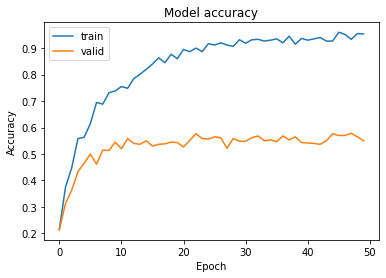

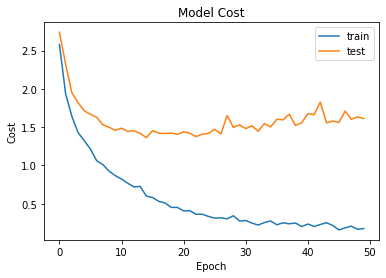

In [15]:
plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

We have started by building a basic model, using the pretrained Xception base and a new classification layer.  It learns well with accuracy reaching over 70% and validation accuracy at 60%.


In [3]:
gc.collect()

0

In [34]:
valid = model.evaluate(test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(71, 71), 
                                                        color_mode='rgb',
                                                        class_mode='categorical',))

Found 100 images belonging to 4 classes.
4/4 [==============================] - 10s 2s/step - loss: 2.5358 - accuracy: 0.4800


In [36]:
a = test_datagen.flow_from_directory(test_data_path,
                                    target_size=(71, 71), 
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=1)

Found 100 images belonging to 4 classes.


In [37]:
species = list(a.class_indices.keys())

In [38]:
R_categories = {y:x for x,y in a.class_indices.items()}
R_categories

{0: 'bgs', 1: 'chk', 2: 'mze', 3: 'wht'}

In [ ]:
# Data Augmentation


----------

In [ ]:
img_width, img_height = 150, 150

size = (150, 150)

train_data_dir = train_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))
validation_data_dir = validation_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))
test_data_dir = test_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:

epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
train_features, train_labels = extract_features(train_dir, 4939)
validation_features, validation_labels = extract_features(validation_dir, 300)
test_features, test_labels = extract_features(test_dir, 300)

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

In [ ]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(12, activation='softmax')
])

## **Training and testing on full data set.**

In [ ]:
# Define directories for training and test images
all_images = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data'

full_train_data_path = os.path.join(all_images, 'train/')
full_test_data_path = os.path.join(all_images, 'test/')
full_val_data_path = os.path.join(all_images, 'validation/')


There are now more images per class for training.

In [ ]:
list_paths = glob.glob(train_data_path + '*')
species = [i.replace(train_data_path,'') for i in list_paths]
print(species)


['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


In [ ]:
for i in species:
    print(i + ': ' + str(len(os.listdir(train_data_path + i))) + ' pictures')